In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
file_root = 'drive/MyDrive/Colab Notebooks/adv_watermark/'

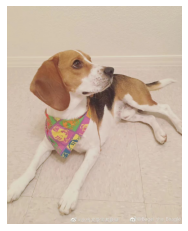

In [ ]:
img = cv2.imread('%sbeagle4.jpg'%file_root)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

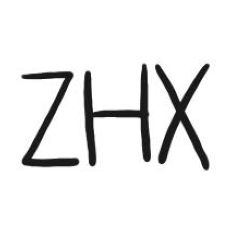

In [ ]:
wm = cv2.imread('%szhx.jpg'%file_root,cv2.IMREAD_GRAYSCALE)
plt.axis('off')
plt.imshow(wm,cmap='gray')

In [ ]:
alpha = 50
block_size = 4
k1 = np.random.randn(block_size)
k2 = np.random.randn(block_size)
img = cv2.copyMakeBorder(img,
              0,(block_size-(img.shape[0] % block_size)),
              0,(block_size-(img.shape[1] % block_size)),
              cv2.BORDER_REPLICATE)

In [ ]:
def dct_img(bk,block_size):
  img_dct_blocks_h = bk.shape[0] // block_size
  img_dct_blocks_w = bk.shape[1] // block_size
  img_dct_blocks = np.zeros(shape=(
      (img_dct_blocks_h,img_dct_blocks_w,block_size,block_size)
  ))
  h_data = np.vsplit(bk,img_dct_blocks_h)
  for h in range(img_dct_blocks_h):
    block_data = np.hsplit(h_data[h],img_dct_blocks_w)
    for w in range(img_dct_blocks_w):
        a_block = block_data[w]
        img_dct_blocks[h,w,...] = cv2.dct(a_block.astype(np.float64))
  return img_dct_blocks

In [ ]:
def embed_wm(img,wm,block_size,k1,k2,alpha):
  wm = np.where(wm<np.mean(wm),0,1)
  yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
  bk = U
  img_dct_blocks = dct_img(bk,block_size)
  dct_embed_result = img_dct_blocks.copy()
  for h in range(wm.shape[0]):
      for w in range(wm.shape[1]):
          k = k1 if wm[h,w] == 1 else k2
          for i in range(block_size):
              dct_embed_result[h,w,i,block_size-1] = \
              img_dct_blocks[h,w,i,block_size-1] + alpha * k[i]
  row = None
  idct_result = None
  for h in range(dct_embed_result.shape[0]):
      for w in range(dct_embed_result.shape[1]):
          block = cv2.idct(dct_embed_result[h,w,...])
          row = block if w == 0 else np.hstack((row,block))
      idct_result = row if h == 0 else np.vstack((idct_result,row))
  img_embed_result_yuv = np.stack((Y,idct_result,V),axis=2).astype(np.uint8)
  img_embed_result_bgr = cv2.cvtColor(img_embed_result_yuv,cv2.COLOR_YUV2BGR)
  img_embed_result = cv2.cvtColor(img_embed_result_bgr,cv2.COLOR_BGR2RGB)
  return img_embed_result

In [ ]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y


def corr2(a, b):
    """
    相关性判断
    """
    a = a - mean2(a)
    b = b - mean2(b)
    r = (a * b).sum() / np.sqrt((a * a).sum() * (b * b).sum())
    return r

In [ ]:
def recover_wm(bk,k1,k2,wm_shape,block_size):
  recover_wm = np.zeros(shape=wm.shape)
  wmed_dct_result = dct_img(bk,block_size)
  p = np.zeros(block_size)
  for h in range(wm_shape[0]):
      for w in range(wm_shape[1]):
          for k in range(block_size):
              p[k] = wmed_dct_result[h,w,k,block_size-1]
          if corr2(p,k1) > corr2(p,k2):
              recover_wm[h,w] = corr2(p,k1)
          else:
              recover_wm[h,w] = 0
  return recover_wm

In [ ]:
wmed_img = embed_wm(img,wm,block_size,k1,k2,alpha)
yuv_img_r = cv2.cvtColor(wmed_img,cv2.COLOR_RGB2YUV)
Y,U,V = yuv_img_r[...,0],yuv_img_r[...,1],yuv_img_r[...,2]
bk = U
r_wm = recover_wm(bk,k1,k2,wm.shape,block_size)

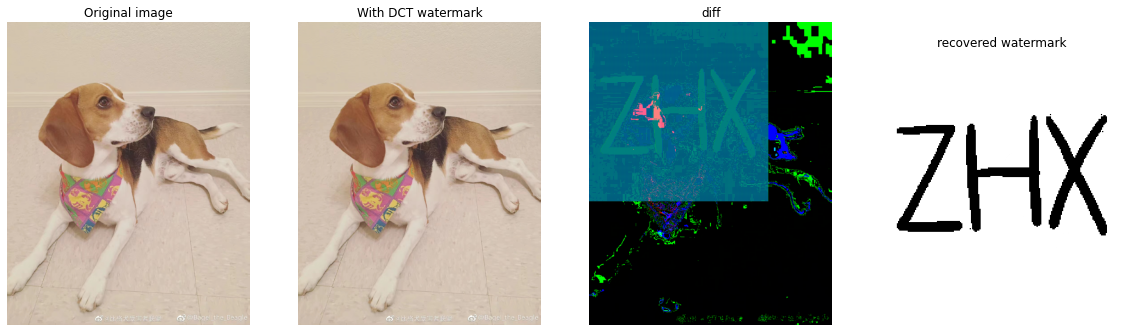

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(wmed_img)
plt.title('With DCT watermark')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(wmed_img-img)
plt.title('diff')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(r_wm,cmap="gray")
plt.title('recovered watermark')
plt.axis('off')
plt.show()

In [ ]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights

In [ ]:
T_3 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([256,256]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
T_2 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([256,256])
])
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet = resnet.cuda()
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def check_classify_path(model,file_path):
  img = cv2.imread(file_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = torch.unsqueeze(T_2(img),0).cuda()
  out = (F.softmax(model(img),dim=1))
  print(torch.max(out))
  print(out.argmax())

In [ ]:
def check_classify(model,img):
  out = (F.softmax(model(img),dim=1))
  print(torch.max(out))
  print(out.argmax())

In [ ]:
from torchvision.transforms import ToPILImage
show = ToPILImage()

In [ ]:
origin = torch.unsqueeze(T_3(img),0).cuda()
check_classify(resnet,origin)

tensor(0.7437, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(162, device='cuda:0')


In [ ]:
import torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pgd_atk = torchattacks.PGD(resnet, eps=8/255, alpha=1/255, steps=40, random_start=True)

In [ ]:
def attack_and_check(T,atk,img,target):
  origin = torch.unsqueeze(T(img),0).cuda()
  adv_images = atk(origin, target)
  out_per = (F.softmax(resnet(adv_images),dim=1))
  print(torch.max(out_per))
  print(out_per.argmax())
  adv_image = show(adv_images.cpu().detach()[0])
  adv_image.show()
  return np.array(adv_image)

In [ ]:
target = torch.tensor([162]).cuda()
pgd_img = attack_and_check(T_3,pgd_atk,img,target)

tensor(0.9990, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(549, device='cuda:0')


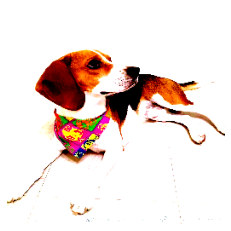

In [ ]:
plt.axis('off')
plt.imshow(pgd_img)

In [ ]:
from torchattacks.attacks.cw import CW
import torch.nn as nn
import torch.optim as optim
class CW_with_trans(CW):
    def __init__(self, model, c=1e-4, kappa=0, steps=1000, lr=0.01, transforms=None):
        super().__init__(model, c, kappa, steps, lr)
        self.transforms = transforms

    def forward(self, images, labels=None):

        images_input = self.transforms(images)
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self._targeted:
            target_labels = self._get_target_label(images_input, labels)

        # w = torch.zeros_like(images).detach() # Requires 2x times
        w = self.inverse_tanh_space(images).detach()
        w.requires_grad = True

        best_adv_images = images.clone().detach()
        best_L2 = 1e10*torch.ones((len(images))).to(self.device)
        prev_cost = 1e10
        dim = len(images.shape)

        MSELoss = nn.MSELoss(reduction='none')
        Flatten = nn.Flatten()

        optimizer = optim.Adam([w], lr=self.lr)

        for step in range(self.steps):
            # Get adversarial images
            adv_images = self.tanh_space(w)

            # Calculate loss
            current_L2 = MSELoss(Flatten(adv_images),
                                 Flatten(images)).sum(dim=1)
            L2_loss = current_L2.sum()

            outputs = self.model(self.transforms(adv_images))
            if self._targeted:
                f_loss = self.f(outputs, target_labels).sum()
            else:
                f_loss = self.f(outputs, labels).sum()

            cost = L2_loss + self.c*f_loss

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            # Update adversarial images
            _, pre = torch.max(outputs.detach(), 1)
            correct = (pre == labels).float()

            # filter out images that get either correct predictions or non-decreasing loss, 
            # i.e., only images that are both misclassified and loss-decreasing are left 
            mask = (1-correct)*(best_L2 > current_L2.detach())
            best_L2 = mask*current_L2.detach() + (1-mask)*best_L2

            mask = mask.view([-1]+[1]*(dim-1))
            best_adv_images = mask*adv_images.detach() + (1-mask)*best_adv_images

            # Early stop when loss does not converge.
            # max(.,1) To prevent MODULO BY ZERO error in the next step.
            if step % max(self.steps//10,1) == 0:
                if cost.item() > prev_cost:
                    return best_adv_images
                prev_cost = cost.item()

        return best_adv_images

In [ ]:
T = transforms.ToTensor()
origin = torch.unsqueeze(T(img),0).cuda()
T_cw = transforms.Compose([
            transforms.Resize([256,256]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
cw_atk = CW_with_trans(model=resnet, c=1, kappa=0, steps=1000, lr=0.0001, transforms=T_cw)

In [ ]:
cw_images = cw_atk(origin, target)

In [ ]:
cw_images = attack_and_check(T,cw_atk,img,target)

tensor(0.0163, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(731, device='cuda:0')


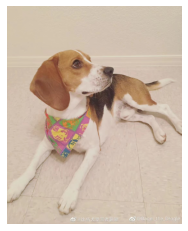

In [ ]:
plt.axis('off')
plt.imshow(cw_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


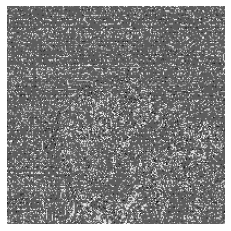

In [ ]:
cw_yuv = cv2.cvtColor(cw_images,cv2.COLOR_RGB2YUV)
Y,U,V = cw_yuv[...,0],cw_yuv[...,1],cw_yuv[...,2]
bk = U
r_wm = recover_wm(bk,k1,k2,wm.shape,block_size)
plt.axis('off')
plt.imshow(r_wm,cmap="gray")

将图像的变换直接添加到CW算法中，可以产生有效的对抗样本\
但如果不考虑对水印的保护，水印将会被破坏\
后续考虑:\
1.查找针对缩放和归一化处理的攻击策略\
2.尝试：对水印部分进行保护（**水印区域不添加对抗扰动**）的cw算法\
（*那么大一块不能attack属实有点不合理*）\
3.尝试：对水印部分**扰动进行限制**的cw算法\
（*问题：如何限制扰动的范围才能使水印得到有效的保护？*）\
（*这里或许可以考虑更改cw算法的优化部分？*）\
4.GAN（总感觉也许遥遥无期QwQ）